# 3D U-Net Inference

This notebook shows how to perform inference on the trained model using both the Keras/TensorFlow model and the OpenVINO model. It also compares the outputs to show that OpenVINO is faster on the same hardware than Keras/TensorFlow and produces the same predictions.

## Always run the OpenVINO setup variable script before using it for the first time.

In [1]:
!source /opt/intel/openvino/bin/setupvars.sh

[setupvars.sh] OpenVINO environment initialized


## If you haven't converted the model already, then use the OpenVINO model optimizer to convert from TensorFlow to OpenVINO.

The file `tf_protobuf/3d_unet_decathlon.pb` should be automatically created at the end of `train.py` by using the best trained Keras HDF5 model file. (From TensorFlow 2.0 and onward, the saved files should all be TensorFlow protobuf (.pb))

# Import the libraries

In [2]:
import sys
import os
import csv

import numpy as np
import logging as log
from time import time
from openvino.inference_engine import IENetwork, IEPlugin

import tensorflow as tf
import keras as K

import nibabel as nib

from tqdm import tqdm

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Get rid of the AVX, SSE warnings


/home/bduser/anaconda3/envs/decathlon/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bduser/anaconda3/envs/decathlon/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bduser/anaconda3/envs/decathlon/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bduser/anaconda3/envs/decathlon

## Runtime arguments

In [3]:
class args:
    number_iter = 5
    device = "CPU"
    stats = False
    plot=False
    csv_file = "test.csv"
    openvino_model = "./openvino_models/FP32/3d_unet_decathlon.xml"
    keras_model = "./saved_model/3d_unet_decathlon.hdf5"
    cpu_extension=""
    plugin_dir=""

## Dice score calculation

In [4]:
def dice_score(pred, truth):
    """
    Sorensen Dice score
    Measure of the overlap between the prediction and ground truth masks
    """
    numerator = np.sum(np.round(pred) * truth) * 2.0
    denominator = np.sum(np.round(pred)) + np.sum(truth)

    return numerator / denominator

## Crop image at center

In [5]:
def crop_img(img, msk, crop_dim, n_channels, n_out_channels):
    """
    Crop the image and mask
    """

    number_of_dimensions = len(crop_dim)

    slices = []

    for idx in range(number_of_dimensions):  # Go through each dimension

        cropLen = crop_dim[idx]
        imgLen = img.shape[idx]

        start = (imgLen-cropLen)//2

        slices.append(slice(start, start+cropLen))

    # No slicing along channels
    slices_img = slices.copy()
    slices_msk = slices.copy()

    slices_img.append(slice(0, n_channels))
    slices_msk.append(slice(0, n_out_channels))

    return img[tuple(slices_img)], msk[tuple(slices_msk)]

## Z normalize image

In [6]:
def z_normalize_img(img):
    """
    Normalize the image so that the mean value for each image
    is 0 and the standard deviation is 1.
    """
    for channel in range(img.shape[-1]):

        img_temp = img[..., channel]
        img_temp = (img_temp - np.mean(img_temp)) / np.std(img_temp)

        img[..., channel] = img_temp

    return img

## Load data from Nifti files

The critical point is that OpenVINO expects the tensor to be in a different order than TensorFlow (channels first versus channels last).  Notice that we simply need to transpose the dimensions after loading to get it in the right order.

In [7]:
def load_data(imgFile, mskFile, crop_dim, n_channels, n_out_channels, openVINO_order=True):
    """
    Modify this to load your data and labels
    """

    imgs = np.empty((len(imgFile),*crop_dim,n_channels))
    msks = np.empty((len(mskFile),*crop_dim,n_out_channels))
    fileIDs = []

    for idx in range(len(imgFile)):

        img_temp = np.array(nib.load(imgFile[idx]).dataobj)
        msk = np.array(nib.load(mskFile[idx]).dataobj)

        if n_channels == 1:
            img = img_temp[:, :, :, [0]]  # FLAIR channel
        else:
            img = img_temp

        # Add channels to mask
        msk[msk > 0] = 1.0
        msk = np.expand_dims(msk, -1)


        # Crop the image to the input size
        img, msk = crop_img(img, msk, crop_dim, n_channels, n_out_channels)

        # z-normalize the pixel values
        img = z_normalize_img(img)

        fileIDs.append(os.path.basename(imgFile[idx]))

        imgs[idx] = img
        msks[idx] = msk

    if openVINO_order:
        imgs = imgs.transpose((0, 4, 1, 2, 3))
        msks = msks.transpose((0, 4, 1, 2, 3))

    return imgs, msks, fileIDs

## Load the OpenVINO model

In [8]:
def load_model(model_xml, fp16=False):
    """
    Load the OpenVINO model.
    """
    log.info("Loading U-Net model to the plugin")

    model_bin = os.path.splitext(model_xml)[0] + ".bin"

    return model_xml, model_bin

## Print the OpenVINO statistics

In [9]:
def print_stats(exec_net, input_data, n_channels, batch_size, input_blob, out_blob, args):
    """
    Prints layer by layer inference times.
    Good for profiling which ops are most costly in your model.
    """

    # Start sync inference
    log.info("Starting inference ({} iterations)".format(args.number_iter))
    log.info("Number of input channels = {}".format(n_channels))
    log.info("Input data shape = {}".format(input_data.shape))
    infer_time = []

    for i in range(args.number_iter):
        t0 = time()
        res = exec_net.infer(
            inputs={input_blob: input_data[0:batch_size, :n_channels]})
        infer_time.append((time() - t0) * 1000)

    average_inference = np.average(np.asarray(infer_time))
    log.info("Average running time of one batch: {:.5f} ms".format(
        average_inference))
    log.info("Images per second = {:.3f}".format(
        batch_size * 1000.0 / average_inference))

    perf_counts = exec_net.requests[0].get_perf_counts()
    log.info("Performance counters:")
    log.info("{:<70} {:<15} {:<15} {:<15} {:<10}".format("name",
                                                         "layer_type",
                                                         "exec_type",
                                                         "status",
                                                         "real_time, us"))
    for layer, stats in perf_counts.items():
        log.info("{:<70} {:<15} {:<15} {:<15} {:<10}".format(layer,
                                                             stats["layer_type"],
                                                             stats["exec_type"],
                                                             stats["status"],
                                                             stats["real_time"]))

## Read CSV file

In [10]:
def read_csv_file(filename):
    """
    Read the CSV file with the image and mask filenames
    """
    imgFiles = []
    mskFiles = []
    with open(filename, "rt") as f:
        data = csv.reader(f)
        for row in data:
            if len(row) > 0:
                imgFiles.append(row[0])
                mskFiles.append(row[1])

    return imgFiles, mskFiles, len(imgFiles)

In [11]:
log.basicConfig(format="[ %(levelname)s ] %(message)s",
                level=log.INFO, stream=sys.stdout)

log.info(args)

log.info("Loading test data from file: {}".format(args.csv_file))

[ INFO ] <class '__main__.args'>
[ INFO ] Loading test data from file: test.csv


## OpenVINO inference

In [12]:
# Plugin initialization for specified device and
#     load extensions library if specified
plugin = IEPlugin(device=args.device, plugin_dirs=args.plugin_dir)
if args.cpu_extension and "CPU" in args.device:
    plugin.add_cpu_extension(args.cpu_extension)

# Read IR
# If using MYRIAD then we need to load FP16 model version
model_xml, model_bin = load_model(args.openvino_model, args.device == "MYRIAD")

log.info("Loading network files:\n\t{}\n\t{}".format(model_xml, model_bin))
net = IENetwork(model=model_xml, weights=model_bin)
# net = IENetwork.from_ir(model=model_xml, weights=model_bin) # Old API

"""
This code checks to see if all of the graphs in the IR are
compatible with OpenVINO. If not, then you'll need to probably
try to load in an extension library from ${INTEL_OPENVINO_DIR}/inference_engine/lib
"""
if "CPU" in plugin.device:
    supported_layers = plugin.get_supported_layers(net)
    not_supported_layers = [
        l for l in net.layers.keys() if l not in supported_layers]
    if len(not_supported_layers) != 0:
        log.error("Following layers are not supported by the plugin "
                  " for specified device {}:\n {}".
                  format(plugin.device, ", ".join(not_supported_layers)))
        log.error("Please try to specify cpu extensions library path "
                  "in sample's command line parameters using -l "
                  "or --cpu_extension command line argument")
        log.error(
            "On CPU this is usually -l ${INTEL_OPENVINO_DIR}/inference_engine/lib/intel64/libcpu_extension_avx2.so")
        log.error(
            "You may need to build the OpenVINO samples directory for this library to be created on your system.")
        log.error(
            "e.g. bash ${INTEL_OPENVINO_DIR}/inference_engine/samples/build_samples.sh will trigger the library to be built.")
        sys.exit(1)


"""
Ask OpenVINO for input and output tensor names and sizes
"""
input_blob = next(iter(net.inputs))  # Name of the input layer
out_blob = next(iter(net.outputs))   # Name of the output layer

log.info("The network inputs are:")
for idx, input_layer in enumerate(net.inputs.keys()):
    log.info("{}: {}, shape = {}".format(idx,input_layer,net.inputs[input_layer].shape))

log.info("The network outputs are:")
for idx, output_layer in enumerate(net.outputs.keys()):
    log.info("{}: {}, shape = {}".format(idx,output_layer,net.outputs[output_layer].shape))


batch_size, n_channels, depth, height, width = net.inputs[input_blob].shape
batch_size, n_out_channels, depth_out, height_out, width_out = net.outputs[
    out_blob].shape

# If you use batch sizes > 1 you'll need to update the for loops below to pass more than 1 image at a time
batch_size = 1
net.batch_size = batch_size

log.info("Batch size = {}".format(batch_size))

# Load data
crop_dim = [height, width, depth]
"""
Read the CSV file with the filenames of the images and masks
"""
imgFiles, mskFiles, num_imgs = read_csv_file(args.csv_file)


"""
Load the data for OpenVINO
"""
input_data, label_data_ov, img_indicies = load_data(imgFiles, mskFiles,
            crop_dim, n_channels, n_out_channels, openVINO_order=True)



# Loading model to the plugin
exec_net = plugin.load(network=net)
del net

if args.stats:
    # Print the latency and throughput for inference
    print_stats(exec_net, input_data, n_channels,
                batch_size, input_blob, out_blob, args)

"""
OpenVINO inference code
input_blob is the name (string) of the input tensor in the graph
out_blob is the name (string) of the output tensor in the graph
Essentially, this looks exactly like a feed_dict for TensorFlow inference
"""
# Go through the sample validation dataset to plot predictions
predictions_ov = np.zeros((num_imgs, n_out_channels,
                        depth_out, height_out, width_out))

log.info("Starting OpenVINO inference")
ov_times = []
for idx in tqdm(range(0, num_imgs)):

    start_time = time()

    res = exec_net.infer(inputs={input_blob: input_data[[idx],:n_channels]})

    ov_times.append(time() - start_time)

    predictions_ov[idx, ] = res[out_blob]

    #print("{}, {}".format(imgFiles[idx], dice_score(res[out_blob],label_data_ov[idx])))


log.info("Finished OpenVINO inference")

del exec_net
del plugin

[ INFO ] Loading U-Net model to the plugin
[ INFO ] Loading network files:
	./openvino_models/FP32/3d_unet_decathlon.xml
	./openvino_models/FP32/3d_unet_decathlon.bin
[ INFO ] The network inputs are:
[ INFO ] 0: MRImages_1, shape = [1, 1, 144, 144, 144]
[ INFO ] The network outputs are:
[ INFO ] 0: PredictionMask_1/Sigmoid, shape = [1, 1, 144, 144, 144]
[ INFO ] Batch size = 1
[ INFO ] Starting OpenVINO inference


100%|██████████| 37/37 [01:53<00:00,  3.06s/it]

[ INFO ] Finished OpenVINO inference


## Keras inference

In [13]:
"""
Load the data for Keras
"""
input_data, label_data_keras, img_indicies = load_data(imgFiles, mskFiles,
                    crop_dim, n_channels, n_out_channels,
                    openVINO_order=False)

# Load OpenVINO model for inference
model = K.models.load_model(args.keras_model, compile=False)

# Inference only Keras
K.backend._LEARNING_PHASE = tf.constant(0)
K.backend.set_learning_phase(False)
K.backend.set_learning_phase(0)
K.backend.set_image_data_format("channels_last")

predictions_keras = np.zeros((num_imgs,
                        height_out, width_out, depth_out, n_out_channels))

log.info("Starting Keras inference")
keras_times = []
for idx in tqdm(range(num_imgs)):

    start_time = time()
    res = model.predict(input_data[[idx],...,:n_channels])

    keras_times.append(time() - start_time)

    #print("{}, {}".format(imgFiles[idx], dice_score(res,label_data_keras[idx])))

    predictions_keras[idx] = res

log.info("Finished Keras inference")

[ INFO ] Starting Keras inference


100%|██████████| 37/37 [03:50<00:00,  6.24s/it]

[ INFO ] Finished Keras inference


In [14]:
import matplotlib.pyplot as plt

%matplotlib inline

## Plot predictions

In [15]:
save_directory = "predictions_openvino"
try:
    os.stat(save_directory)
except:
    os.mkdir(save_directory)

In [16]:
def plot_predictions(idx):
    """
    Evaluate model with Dice metric
    """
    out_channel = 0
    slice_no = 102
    
    img = input_data[[idx],...,:n_channels]
    ground_truth = label_data_keras[idx, :, :, :, out_channel]

    # Transpose the OpenVINO prediction back to NCHWD (to be consistent with Keras)
    pred_ov = np.transpose(predictions_ov, [0,2,3,4,1])[idx, :, :, :, out_channel]
    pred_keras = predictions_keras[idx, :, :, :, out_channel]

    dice_ov = dice_score(pred_ov, ground_truth)
    dice_keras = dice_score(pred_keras, ground_truth)

    plt.figure(figsize=(15,15))
    plt.subplot(1,4,1)
    plt.imshow(img[0,:,:,slice_no,0], cmap="bone")
    plt.title("MRI")
    
    plt.subplot(1,4,2)
    plt.imshow(ground_truth[:,:,slice_no])
    plt.title("Ground truth")
    
    plt.subplot(1,4,3)
    plt.imshow(pred_keras[:,:,slice_no])
    plt.title("Keras\nDice {:.6f}".format(dice_keras))
    
    plt.subplot(1,4,4)
    plt.imshow(pred_ov[:,:,slice_no])
    plt.title("OpenVINO\nDice {:.6f}".format(dice_ov))
    
    log.info("Maximum Absolute Pixel Difference in Predictions is {:.6f}".format(np.max(np.abs(pred_ov[:,:,slice_no] - pred_keras[:,:,slice_no]))))
    

## Plot some sample predictions

Here we show the MRI input, the ground truth mask, the Keras/TF model prediction, and the OpenVINO model prediction. We also calculate the maximum absolute pixel difference which is usually < 1e-5 (on the order of floating point precision).

[ INFO ] Maximum Absolute Pixel Difference in Predictions is 0.000003


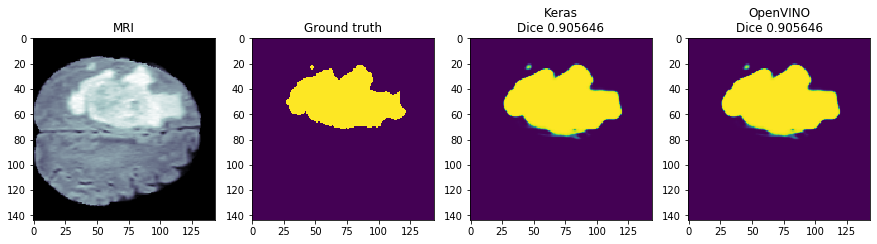

In [17]:
plot_predictions(0)

[ INFO ] Maximum Absolute Pixel Difference in Predictions is 0.000001


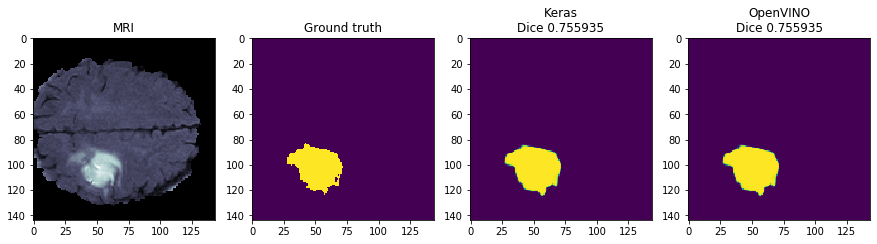

In [18]:
plot_predictions(2)

[ INFO ] Maximum Absolute Pixel Difference in Predictions is 0.000003


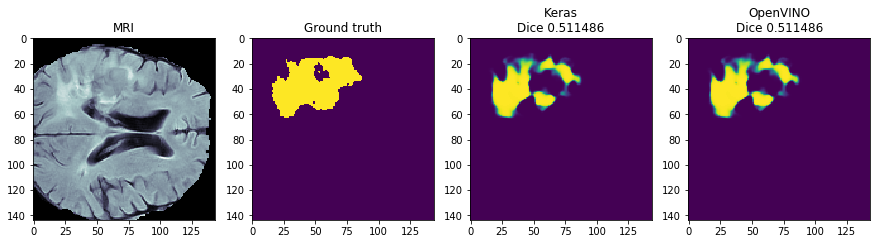

In [19]:
plot_predictions(7)

[ INFO ] Maximum Absolute Pixel Difference in Predictions is 0.000002


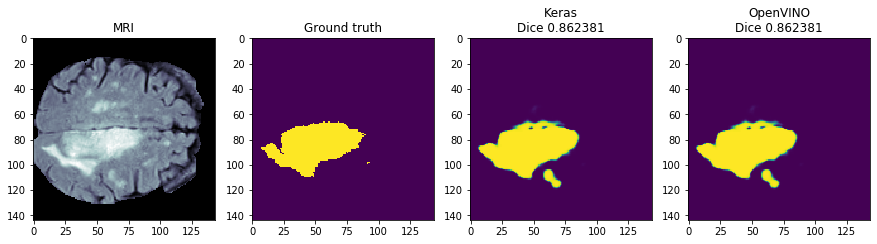

In [20]:
plot_predictions(17)

[ INFO ] Maximum Absolute Pixel Difference in Predictions is 0.000002


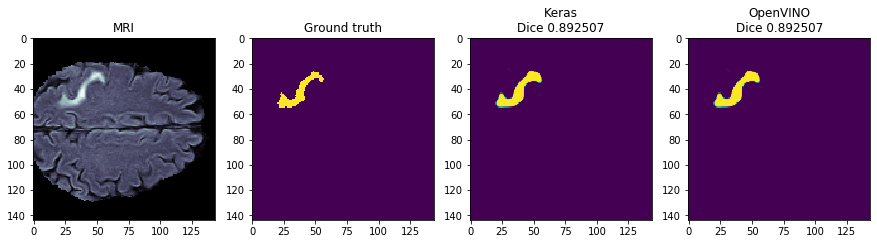

In [21]:
plot_predictions(25)

[ INFO ] Maximum Absolute Pixel Difference in Predictions is 0.000002


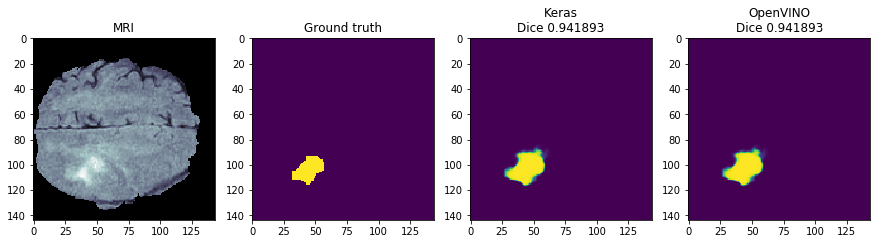

In [22]:
plot_predictions(31)

[ INFO ] Maximum Absolute Pixel Difference in Predictions is 0.000001


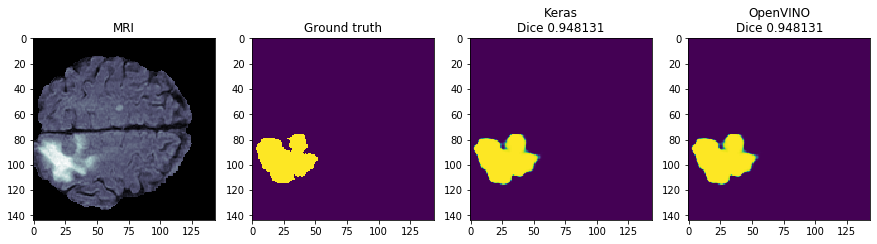

In [23]:
plot_predictions(35)

## Inference times

In [24]:
log.info("Average inference time: \n"
         "OpenVINO = {} seconds (s.d. {})\n"
         "Keras/TF = {} seconds (s.d. {})\n".format(np.mean(ov_times),
         np.std(ov_times),
         np.mean(keras_times),
         np.std(keras_times)))
log.info("Raw OpenVINO inference times = {} seconds".format(ov_times))
log.info("Raw Keras inference times = {} seconds".format(keras_times))

[ INFO ] Average inference time: 
OpenVINO = 3.055176625380645 seconds (s.d. 0.0054455910167676425)
Keras/TF = 6.232963955080187 seconds (s.d. 0.2853247725588934)

[ INFO ] Raw OpenVINO inference times = [3.0732436180114746, 3.0637261867523193, 3.0587058067321777, 3.0705108642578125, 3.0539660453796387, 3.061385154724121, 3.05378794670105, 3.0578958988189697, 3.0497913360595703, 3.054926633834839, 3.051311492919922, 3.05854868888855, 3.051579713821411, 3.0533249378204346, 3.049438953399658, 3.0608596801757812, 3.0523715019226074, 3.0534632205963135, 3.0544302463531494, 3.0594611167907715, 3.0526585578918457, 3.0495920181274414, 3.05069637298584, 3.054830312728882, 3.050689935684204, 3.054269552230835, 3.0495619773864746, 3.0546066761016846, 3.0510599613189697, 3.0515942573547363, 3.0517609119415283, 3.0582938194274902, 3.0510454177856445, 3.0493922233581543, 3.053632974624634, 3.059577465057373, 3.0555436611175537] seconds
[ INFO ] Raw Keras inference times = [7.90528130531311, 6.26784